In [26]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder

from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, SGDRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import VotingClassifier, BaggingClassifier, VotingRegressor, BaggingRegressor
from mlxtend.classifier import StackingClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn import set_config
set_config(display="diagram")

In [27]:
df = pd.read_csv('atp.csv')
df.shape

(50517, 38)

In [28]:
X=df.drop(columns=['Date', 'Winner', 'Loser', 'Comment', 'ATP', 
                   'WRank', 'LRank', 'B365W', 'B365L','W1', 'L1', 'W2', 'L2',  'W3', 'L3', 
                   'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets', 'FavRank', 'FavOdd', 
                   'TotalSets', 'TotalGames', 'TotalWgames', 'TotalLgames', 'L2M'])

# y_rank=df['FavRank']
# y_odd=df['FavOdd']
# y_sets=df['TotalSets']
y_games=df['TotalGames']
# y_l2m=df['L2M']

In [29]:
X.columns

Index(['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round',
       'Best of', 'GapRank', 'GapOdd', 'Month'],
      dtype='object')

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y_games, test_size=0.25, random_state=42)

In [31]:
df_pred=pd.DataFrame()
df_pred['target']=y_test

#### VotingRegressor

In [32]:
algo_voting=VotingRegressor(estimators=[
    ('knn', KNeighborsRegressor()), 
    ('lr', LinearRegression()), 
    ('dt', DecisionTreeRegressor())])

In [33]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'Best of', 'Month']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_voting = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', algo_voting)
])

pipeline_voting

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'Best of', 'Month']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('regressor',
                 VotingRegressor(estimators=[('knn', KNeighborsRegressor()),
                                             ('lr', LinearRegression()),
                                             ('dt',
                                              DecisionTreeRegressor())]))])

In [34]:
pipeline_voting.fit(X_train, y_train)

y_train_pred=pipeline_voting.predict(X_train)
y_test_pred=pipeline_voting.predict(X_test)

print(pipeline_voting.score(X_train,y_train))
print(pipeline_voting.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

In [ ]:
df_pred['voting']=pipeline_voting.predict(X_test)

#### Boosting

In [ ]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'Best of', 'Month']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_adaboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostRegressor())
])

pipeline_adaboost

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'Best of', 'Month']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', AdaBoostRegressor())])

In [ ]:
pipeline_adaboost.fit(X_train, y_train)

y_train_pred=pipeline_adaboost.predict(X_train)
y_test_pred=pipeline_adaboost.predict(X_test)

print(pipeline_adaboost.score(X_train,y_train))
print(pipeline_adaboost.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse train :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.16565039978166807
0.16041321528349217
rmse train : 4.924039483325102
rmse train : 5.23125295639429


In [ ]:
df_pred['adaboost']=pipeline_adaboost.predict(X_test)

#### Bagging

In [ ]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'Best of', 'Month']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_bagging = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BaggingRegressor(LinearRegression()))
])

pipeline_bagging

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'Best of', 'Month']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier',
                 BaggingRegressor(base_estimator=LinearRegression()))])

In [ ]:
pipeline_bagging.fit(X_train, y_train)

y_train_pred=pipeline_bagging.predict(X_train)
y_test_pred=pipeline_bagging.predict(X_test)

print(pipeline_bagging.score(X_train,y_train))
print(pipeline_bagging.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.2835975237979652
0.2733126222759088
rmse train : 4.562743285943345
rmse test : 4.866836226763719


In [ ]:
df_pred['bagging']=pipeline_bagging.predict(X_test)

#### Linear Regression

In [ ]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'Best of', 'Month']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_linearreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearRegression())
])

pipeline_linearreg

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'Best of', 'Month']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', LinearRegression())])

In [ ]:
pipeline_linearreg.fit(X_train, y_train)

y_train_pred=pipeline_linearreg.predict(X_train)
y_test_pred=pipeline_linearreg.predict(X_test)

print(pipeline_linearreg.score(X_train,y_train))
print(pipeline_linearreg.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.2838296162580285
0.2735350640616042
rmse train : 4.562004131534975
rmse test : 4.866091291160803


In [ ]:
df_pred['linearreg']=pipeline_linearreg.predict(X_test)

#### DecisionTree

In [ ]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'Best of', 'Month']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeRegressor())
])

pipeline_dt

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'Best of', 'Month']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('classifier', DecisionTreeRegressor())])

In [ ]:
pipeline_dt.fit(X_train, y_train)

y_train_pred=pipeline_dt.predict(X_train)
y_test_pred=pipeline_dt.predict(X_test)

print(pipeline_dt.score(X_train,y_train))
print(pipeline_dt.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.9824533751590979
-0.3810437437575056
rmse train : 0.7140757601968265
rmse test : 6.70929119071967


In [ ]:
df_pred['decisiontree']=pipeline_dt.predict(X_test)

#### RandomForest

In [ ]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'Best of', 'Month']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

pipeline_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'Best of', 'Month']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('regressor', RandomForestRegressor())])

In [ ]:
pipeline_rf.fit(X_train, y_train)

y_train_pred=pipeline_rf.predict(X_train)
y_test_pred=pipeline_rf.predict(X_test)

print(pipeline_rf.score(X_train,y_train))
print(pipeline_rf.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.8737168782369734
0.1851538255698184
rmse train : 1.9156675831844925
rmse test : 5.153600376606351


In [ ]:
df_pred['randomforest']=pipeline_rf.predict(X_test)

#### GradientBoosting

In [ ]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'Best of', 'Month']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_gradientboosting = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
])

pipeline_gradientboosting

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'Best of', 'Month']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('regressor', GradientBoostingRegressor())])

In [ ]:
pipeline_gradientboosting.fit(X_train, y_train)

y_train_pred=pipeline_gradientboosting.predict(X_train)
y_test_pred=pipeline_gradientboosting.predict(X_test)

print(pipeline_gradientboosting.score(X_train,y_train))
print(pipeline_gradientboosting.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.30283868245077594
0.2829000228727546
rmse train : 4.501053101187998
rmse test : 4.834624828535755


In [ ]:
df_pred['gradientboosting']=pipeline_gradientboosting.predict(X_test)

#### SGD Regressor

In [ ]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'Best of', 'Month']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_sgd = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SGDRegressor())
])

pipeline_sgd

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'Best of', 'Month']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('regressor', SGDRegressor())])

In [ ]:
pipeline_sgd.fit(X_train, y_train)

y_train_pred=pipeline_sgd.predict(X_train)
y_test_pred=pipeline_sgd.predict(X_test)

print(pipeline_sgd.score(X_train,y_train))
print(pipeline_sgd.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.28214114470219986
0.2726470710292265
rmse train : 4.567378746024662
rmse test : 4.86906441160736


In [ ]:
df_pred['sgd']=pipeline_sgd.predict(X_test)

#### Comparatifs prédictions

In [ ]:
df_pred.describe()

,target,voting,adaboost,bagging,linearreg,decisiontree,randomforest,gradientboosting,sgd
count,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000
mean,21.065400,21.051179,21.991927,21.055228,21.050612,21.065571,21.092532,21.044188,21.116441
std,5.709395,3.480524,4.394125,2.925972,2.909096,5.580738,3.576270,2.940971,2.849167
min,12.000000,14.593368,19.256430,9.203500,9.365845,12.000000,14.780000,17.048470,9.595888
25%,18.000000,19.006552,19.898690,19.463217,19.464100,18.000000,19.110000,19.537864,19.573305
50%,20.000000,20.097339,20.020975,20.010036,20.000259,20.000000,19.970000,19.914894,20.075146
75%,22.000000,21.528701,20.020975,20.666766,20.642441,23.000000,21.230000,20.222811,20.681390
max,170.000000,51.918077,60.829025,29.112448,28.951599,86.000000,52.470000,32.907937,29.909076


In [ ]:
df_pred.boxplot(figsize=(15,8))

<Axes: >

#### Voting avec AdaBoost, DecisionTree & RandomForest

In [ ]:
algo_voting_2=VotingRegressor(estimators=[
    ('ada', AdaBoostRegressor()), 
    ('dt', DecisionTreeRegressor()),
    ('rf', RandomForestRegressor())])

In [ ]:
categorical_columns = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round']
numeric_columns = ['GapRank', 'GapOdd', 'Best of', 'Month']

rob_scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Création du préprocesseur pour les colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('rob_scaler', rob_scaler, numeric_columns),
        ('encoder', ohe, categorical_columns)
    ])

# Création du pipeline avec le préprocesseur et le classificateur SVC
pipeline_voting_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting', algo_voting_2)
])

pipeline_voting_2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler', RobustScaler(),
                                                  ['GapRank', 'GapOdd',
                                                   'Best of', 'Month']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'Tournament',
                                                   'Series', 'Court', 'Surface',
                                                   'Round'])])),
                ('voting',
                 VotingRegressor(estimators=[('ada', AdaBoostRegressor()),
                                             ('dt', DecisionTreeRegressor()),
                                             ('rf',
                                              RandomForestRegressor())]))])

In [ ]:
pipeline_voting_2.fit(X_train, y_train)

y_train_pred=pipeline_voting_2.predict(X_train)
y_test_pred=pipeline_voting_2.predict(X_test)

print(pipeline_voting_2.score(X_train,y_train))
print(pipeline_voting_2.score(X_test,y_test))
print("rmse train :", (mean_squared_error(y_train,y_train_pred))**0.5)
print("rmse test :", (mean_squared_error(y_test,y_test_pred))**0.5)

0.8193481866694082
0.1537747626512339
rmse train : 2.2912298476805333
rmse test : 5.251893496394507


In [ ]:
df_pred['voting_2']=pipeline_voting_2.predict(X_test)

In [ ]:
df_pred.describe()

,target,voting,adaboost,bagging,linearreg,decisiontree,randomforest,gradientboosting,sgd,voting_2
count,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000
mean,21.065400,21.051179,21.991927,21.055228,21.050612,21.065571,21.092532,21.044188,21.116441,21.382302
std,5.709395,3.480524,4.394125,2.925972,2.909096,5.580738,3.576270,2.940971,2.849167,4.009349
min,12.000000,14.593368,19.256430,9.203500,9.365845,12.000000,14.780000,17.048470,9.595888,15.759243
25%,18.000000,19.006552,19.898690,19.463217,19.464100,18.000000,19.110000,19.537864,19.573305,19.042775
50%,20.000000,20.097339,20.020975,20.010036,20.000259,20.000000,19.970000,19.914894,20.075146,20.114429
75%,22.000000,21.528701,20.020975,20.666766,20.642441,23.000000,21.230000,20.222811,20.681390,21.644060
max,170.000000,51.918077,60.829025,29.112448,28.951599,86.000000,52.470000,32.907937,29.909076,71.966514


In [ ]:
df_pred.to_csv('res.csv', index=False)

In [ ]:
df_pred=pd.read_csv('res.csv')
df_pred

,target,voting,adaboost,bagging,linearreg,decisiontree,randomforest,gradientboosting,sgd,voting_2
0,43.0,24.301164,31.973117,27.734293,27.703491,19.0,28.645833,28.352181,27.674764,25.432509
1,22.0,17.989172,20.020975,19.882016,19.767517,14.0,18.290000,19.757886,19.869650,17.230246
2,22.0,19.629237,19.898690,19.906281,19.887711,19.0,20.290000,19.517610,19.892993,19.510726
3,23.0,21.102065,20.003313,20.471655,20.506195,22.0,21.660000,20.450311,20.461385,21.291465
4,42.0,29.924422,37.739520,28.010248,27.973267,25.0,34.280000,28.701936,27.884804,33.634392
...,...,...,...,...,...,...,...,...,...,...
12625,23.0,19.618307,19.926468,19.556693,19.654922,21.0,19.800000,19.636931,19.678880,20.244067
12626,20.0,21.671474,20.020975,21.463165,21.814423,22.0,20.400000,20.494243,20.678643,21.134799
12627,21.0,19.077591,19.967421,20.217288,20.232773,17.0,19.240000,19.936177,20.310592,18.691465
12628,22.0,20.497418,20.020975,21.177112,21.092255,19.0,20.440000,20.546166,21.014329,19.871465


In [ ]:
df_pred.describe()

,target,voting,adaboost,bagging,linearreg,decisiontree,randomforest,gradientboosting,sgd,voting_2
count,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000
mean,21.065400,21.051179,21.991927,21.055228,21.050612,21.065571,21.092532,21.044188,21.116441,21.382302
std,5.709395,3.480524,4.394125,2.925972,2.909096,5.580738,3.576270,2.940971,2.849167,4.009349
min,12.000000,14.593368,19.256430,9.203500,9.365845,12.000000,14.780000,17.048470,9.595888,15.759243
25%,18.000000,19.006552,19.898690,19.463217,19.464100,18.000000,19.110000,19.537864,19.573305,19.042775
50%,20.000000,20.097339,20.020975,20.010036,20.000259,20.000000,19.970000,19.914894,20.075146,20.114429
75%,22.000000,21.528701,20.020975,20.666766,20.642441,23.000000,21.230000,20.222811,20.681390,21.644060
max,170.000000,51.918077,60.829025,29.112448,28.951599,86.000000,52.470000,32.907937,29.909076,71.966514


<Axes: >

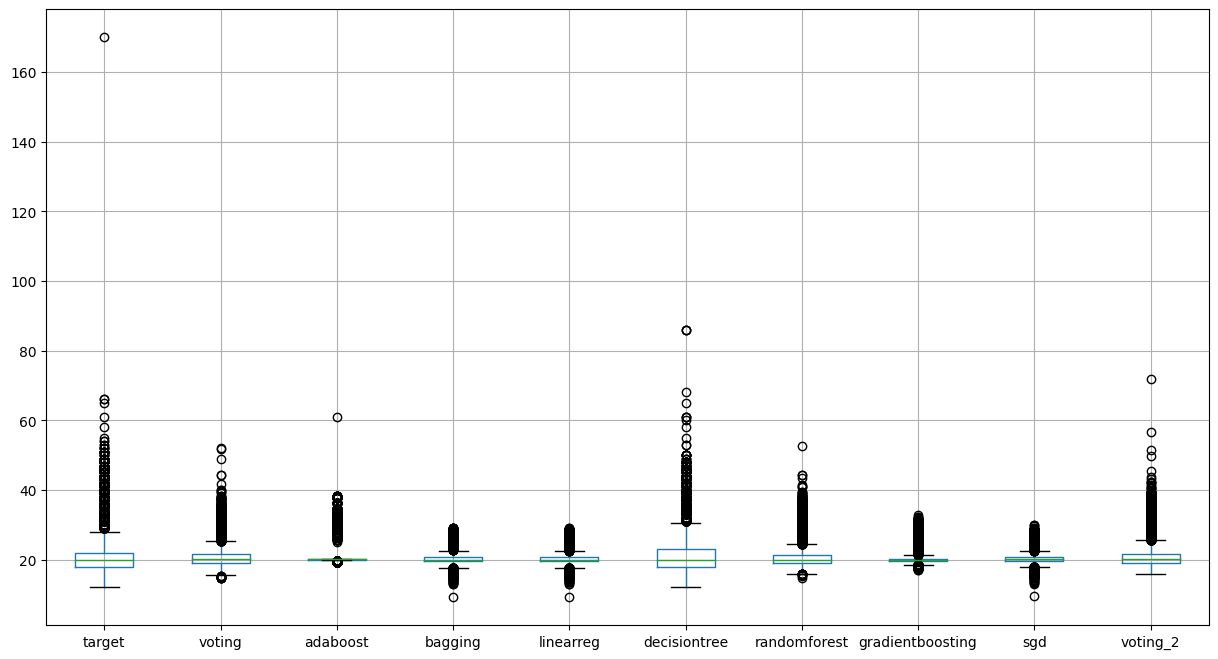

In [ ]:
df_pred.boxplot(figsize=(15,8))